In [2]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

# IMPLEMENTACION CON GRADCAM + EXPLICACIÓN

#### 1. Cargar modelo

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*16*16, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = SimpleCNN()
model.load_state_dict(torch.load("modelo_gatos_perros.pth", map_location="cpu"))
model.eval()


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

#### 2. Variables globales para Grad-Cam y funciones hook

In [4]:
activaciones = None
gradientes = None

def guardar_activaciones(module, input, output):
    global activaciones
    activaciones = output

def guardar_gradientes(module, grad_input, grad_output):
    global gradientes
    gradientes = grad_output[0]

#### 3. Registrar hooks en la última capa convolucional y Transformaciones de preprocesamiento

In [ ]:
ultima_conv = model.features[6]

ultima_conv.register_forward_hook(guardar_activaciones)
ultima_conv.register_backward_hook(guardar_gradientes)

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

#### 4. Funcion Grad-Cam

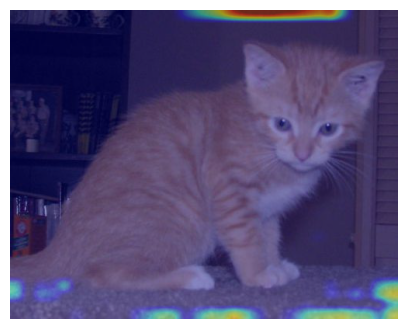

In [ ]:
def gradcam(ruta):
    img = Image.open(ruta).convert("RGB")
    tensor = transform(img).unsqueeze(0) 

    out = model(tensor)
    clase = out.argmax().item()

    model.zero_grad()
    out[0, clase].backward()

    pesos = gradientes.mean(dim=(2, 3), keepdim=True)    

    probs = torch.softmax(out, dim=1)
    p = float(probs[0, clase])
    etiquetas = ["cat", "dog"]
    print("Predicción:", etiquetas[clase], " - prob:", p)      

    mapa = (pesos * activaciones).sum(dim=1, keepdim=True)    

    mapa = mapa[0, 0]                                        

    mapa = torch.relu(mapa)
    mapa = mapa / (mapa.max() + 1e-8)                         

    mapa = mapa.detach().cpu().numpy()                        
    mapa = np.uint8(255 * mapa)                                
    heatmap = Image.fromarray(mapa, mode="L").resize(img.size)

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.imshow(heatmap, cmap="jet", alpha=0.45)
    plt.axis("off")
    plt.show()
    
gradcam("data/val/cats/cat.4003.jpg")